In [1]:
# sys
import os
import os.path as op
import sys

# basics
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

from shapely.geometry import Polygon, Point
import rioxarray
from pyproj import CRS
import geopandas as gpd

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# dependencies
from lib import plot_sat, sat, io
from lib.config import *

# warnings
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Selection of CSIRO spectral stations over the ESTELA area

## Evaluation of energy source

In [2]:
p_data = op.join(os.getcwd(), '..', '..', 'data')

In [3]:
est = xr.open_dataset(op.join(p_data,'Estela_samoa.nc'), decode_times=False)

est = est.sel(time='ALL')
est = est.assign({'estela_mask':(('latitude','longitude'),np.where(est.F.values>0,1,np.nan))})
estela_mask = est.estela_mask # mask for slp

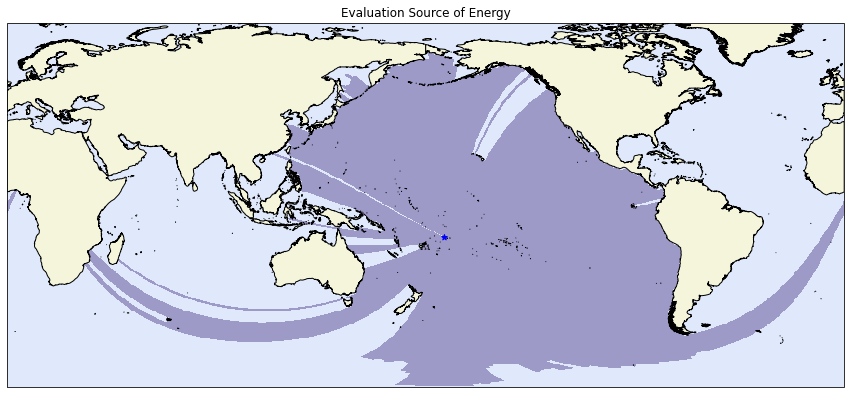

In [4]:
figsize = (15,15)
title = 'Evaluation Source of Energy'
fig, ax = plot_sat.estela_map(figsize, title, estela_mask)

## Global Spectral Stations

In [6]:
glob_CSIRO = xr.open_dataset(op.join(p_data, 'ww3.202101_spec.nc'))

In [ ]:
#glob_CSIRO.to_netcdf(op.join(p_data, 'ww3.202101_spec.nc'))

In [7]:
# Select n_days before forecast day
n_days = 30
init_time = forecast_day - datetime.timedelta(n_days)
glob_CSIRO = glob_CSIRO.sel(time=slice(init_time, forecast_day))

In [8]:
estela_mask_01 = estela_mask.fillna(0)

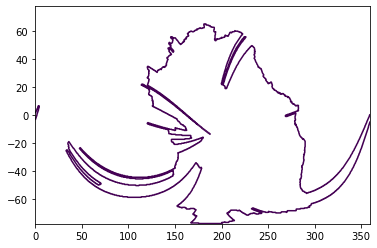

In [9]:
cn = plt.contour(estela_mask_01.longitude, estela_mask_01.latitude, estela_mask_01.values, levels=[0.5])
cont = cn.allsegs
maxi = 0
for pcirc, circ in enumerate(cont[0]):
    if len(cont[0][pcirc]) > maxi:
        maxi = len(cont[0][pcirc])
        pmax = pcirc
df = pd.DataFrame({'X': cont[0][pmax][:,0], 'Y':cont[0][pmax][:,1]})

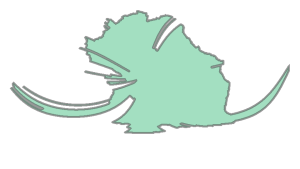

In [10]:
# create shapely polygon
geom_list = [(x, y) for x, y  in zip(df['X'], df['Y'])]
geom_list_1 = [Point(i[0], i[1]) for i in geom_list]
poly = Polygon([[p.x, p.y] for p in geom_list_1])
poly

In [11]:
geodf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[poly])

In [12]:
# create rioxarray
xds = glob_CSIRO.isel(time=0)[['longitude', 'latitude']].to_dataframe().reset_index().set_index(['longitude', 'latitude'])[['station']].to_xarray()

In [13]:
xds = xds.sel(longitude=slice(0, None))

In [14]:
crs_wgs = CRS.from_string('EPSG:4326') 
xds = xds.rio.write_crs(crs_wgs)

In [15]:
# select only int coordinates to avoid spectra around Australia
array_lons, array_lats = [], []
for lons in xds.longitude.values:
    if lons %10 == 0:
        array_lons.append(lons)
        
for lats in xds.latitude.values:
    if lats %10 == 0:
        array_lats.append(lats)

array_lons = np.unique(array_lons)
array_lats = np.unique(array_lats)

In [16]:
xds = xds.sel(longitude=array_lons, latitude=array_lats)
xds_clip = xds.rio.clip(geodf.geometry.values, crs=geodf.crs)
stations_id = xds_clip.to_dataframe().dropna()

In [17]:
xds_data = glob_CSIRO.sel(station=[int(i) for i in stations_id.station])

Text(0.5, 1.0, 'CSIRO Spectral Stations')

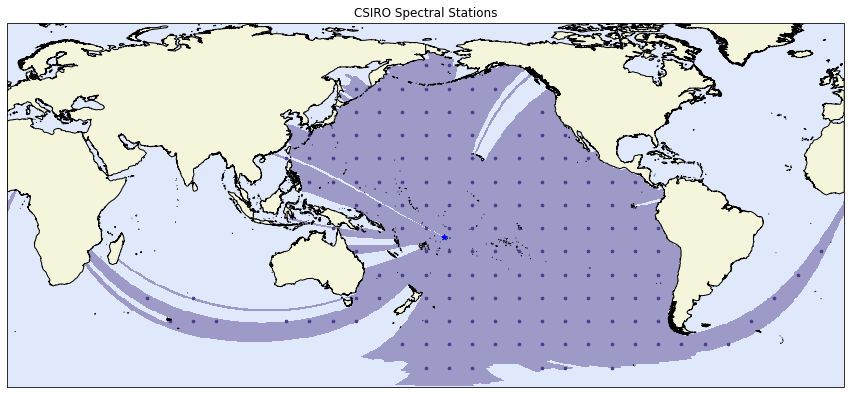

In [18]:
fig, ax = plot_sat.estela_map(figsize, title, estela_mask)
ax.scatter(stations_id.index.get_level_values(0), stations_id.index.get_level_values(1), transform=ccrs.PlateCarree(), s=7, c='darkslateblue')
ax.set_title('CSIRO Spectral Stations')

In [19]:
xds_data = xds_data[['efth', 'longitude', 'latitude', 'efth', 'wnd', 'wnddir']]
xds_data['time'] = xds_data.time.dt.round('1H')

In [20]:
xds_data

<xarray.Dataset>
Dimensions:    (time: 697, station: 164, frequency: 29, direction: 24)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-01-30
  * station    (station) int32 3410 3376 3377 3412 3378 ... 3400 3436 3465 3494
  * frequency  (frequency) float32 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * direction  (direction) float32 82.5 67.5 52.5 37.5 ... 127.5 112.5 97.5
Data variables:
    efth       (time, station, frequency, direction) float32 ...
    longitude  (time, station) float32 ...
    latitude   (time, station) float32 ...
    wnd        (time, station) float32 ...
    wnddir     (time, station) float32 ...
Attributes: (12/16)
    product_name:           ww3.202101_spec.nc
    area:                   spectral resolution for points
    data_type:              OCO spectra 2D
    format_version:         1.1
    southernmost_latitude:  -70.0000000°
    northernmost_latitude:  71.5999985°
    ...                     ...
    minimum_altitude:       n/a
    maximum_altitude:       n/a
    altitude_resolution:    n/a
    start_date:             2021-01-01T00:00:00Z
    stop_date:              2021-02-01T00:00:00Z
    field_type:             hourly

In [ ]:
sys.exit()

In [21]:
xds_data = xds_data.isel(time=slice(None, None, 3))

In [23]:
xds_data.to_netcdf(op.join(r'/media/administrador/DiscoHD/Documentos/notebook_projects/cfosat-forecast/output', 'ds_data_csiro1.nc'))

In [ ]:
xds_data